In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
from scipy.integrate import odeint

import os
from netCDF4 import Dataset
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

In [34]:
# Import and apply style file for plots
plt.style.use("mpl.style")
%matplotlib inline

In [35]:
pwd = os.getcwd()
pwd

'/home/epalermo/test/rheo_bench/jpynb_scripts'

### Table of Contents

* [Functions](#Functions)
    * [General](#general)
        * [File Handling](#file_handling)
        * [Extract LAMMPS Data](#extract_LAMMPS_data)
        * [Plotting](#plotting)
* [Test Cases](#test_cases)
    * [Taylor-Green Vortex](#TG_funcs)
    * [Poiseuille Flow](#PF_funcs)
    * [Extended Droplet](#ED_funcs)
    * [Kernel Convergence - Velocity Gradient](#gradv_funcs)
    * [Kernel Convergence - Surface Normals](#surf_funcs)

# Functions <a class="anchor" id="Functions"></a>


### File Handling <a class="anchor" id="file_handling"></a>

In [36]:
#Compile all filenames in a given directory into a dictionary
#value=filepath, key = run properties
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        run_code = file.split(".")[0]

        #Add the files to datafiles dictionary
        data_files[run_code]= filepath + "/" + file
    return data_files

#Collect run info from a file name
def parse_file_name(run):
    run_info_coded = run.split("_")
    #Parse the string and perform type conversions and calculations
    run_info_decoded = [] #to be stored in a df
    numerical_params = {} #to be used in scaling calculations
    for count, param in enumerate(run_info_coded):
        #Handling depends on the variable
        if namekey[count] == "var0":
            run_info_decoded.append(var0_key[param])
        elif namekey[count] == "kernel_type":
            run_info_decoded.append(var1_key[param])
        elif namekey[count] == "sf":
            sf = 1/int(param)
            run_info_decoded.append(sf)
            numerical_params[namekey[count]]=sf
        elif namekey[count] == "hd":
            hd = param.replace("p",".")
            hd = float(hd)
            run_info_decoded.append(hd)
            numerical_params[namekey[count]]=hd
        elif namekey[count] == "eta":
            eta = param.replace("p",".")
            eta = float(eta)
            run_info_decoded.append(eta)
            numerical_params[namekey[count]]=eta
        elif namekey[count] == "fext":
            fext = float(param)
            run_info_decoded.append(fext)
        else:
            print("missing param key")
    run_info_decoded.append(run)
    
    return run_info_decoded,numerical_params


#Calculate any dependent vars
def dependent_vars(numerical_params):
    L_z = h3*(d-2)*sf #Account for L_z if d=3
    n = 1/sf**d #Number density - number of particles per volume
    mp = rho0/n #Mass of particles (density is constant)
    if d == 3:
        N = R*R*L_z/sf**d # Total number of atoms
    elif d == 2:
        N = R*R/sf**d 
    return numerical_params

# def gather_run_info(run,data_files):
#     run_info, numerical_params = parse_file_name(run)
#     ds = Dataset(data_files[run])
#     mp, N = scaling_vars(run)
#     run_info.append(sf)

#     return run_info, ds, sf, mp, N

def gen_col_names(namekey):
    col_names = namekey
    col_names.append("run_code")
    return col_names

def generate_df(data_files,col_names):
    df =pd.DataFrame(columns=col_names)
    for run in data_files:
    #Gather run info from the file name
        run_info, numerical_params = parse_file_name(run)
        ds = Dataset(data_files[run])
        run_df = {}
        for count,value in enumerate(run_info):
            run_df[col_names[count]]=value
        df = df.append(run_df,ignore_index=True)
    return df, ds, run_info

### LAMMPS Data Calculations <a class="anchor" id="extract_LAMMPS_data"></a>

In [37]:
#Returns coordinates and velocities for all particles at each timestep
def extract_velocity_data(ds):
    td = ds["time"][:]
    xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
    yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
    vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
    vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
    return td,xd,yd,vxd,vyd

def calc_KE(td,xd,yd,vxd,vyd,mp):
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd
    return E_tot
    

### Plotting <a class="anchor" id="plotting"></a>

In [38]:
#Plot types

#Normalized Error Plot#
#Input is a dataframe with columns ["shifting","CRK","sf","L1 norm"]
#L1 will vary, e.g. viscosity, surface normal, velocity gradient, etc.
def plot_normalized_error(all_run_info):
    df = pd.DataFrame(all_run_info, columns=["var0","CRK","sf","Surf Normal Normalized Error"])    
    #df.sort_values(by=["sf","CRK"], inplace=True)
    df.sort_values(by=["sf"], inplace=True)
    L1_label = df.iloc[:,-1:].columns[0]
    for i in df["var0"].unique():
        df_1 = df[df["var0"]==i]
        for j in df_1["CRK"].unique():
            df_2 = df_1[df_1["CRK"]==j]
            df_2 = df_2.sort_values(by=["sf"])
            label = j
            plt.loglog(R/df_2["sf"],df_2[L1_label],
                       marker=plot_key[j][0],
                       linestyle=plot_key[i],
                       markerfacecolor="None",
                       color=plot_key[j][1],
                       label=label)
            #print(df_2)
            

#Generic y vs x profile (e.g. velocity vs time)        
def plot_profile(x,y,run_info, ax, plot_type, plot_key):
    ax = ax
    if plot_type == "data":
        ax.plot(x, y,
                        linestyle=plot_key[run_info[0]],
                        marker=plot_key[run_info[1]][0],
                        markevery=0.2,
                        markerfacecolor="None",
                        color=plot_key[run_info[1]][1],
                        label = run_info[1])
    if plot_type == "analytic":
        ax.plot(x, y,
                   label = "Analytic",
                   color="red",
                   linestyle="solid")

In [39]:
#Plot formatting

#Retrieve the default labels and handles
def order_labels(ax):
    label_order_dict = {"Quintic":0,"CRK0":1,"CRK1":2,"CRK2":3,"Analytic":4,"other":5}
    handles,labels = ax.get_legend_handles_labels()
    label_order_unsorted = []
    labels_sorted = []
    for label in labels:
        if label in label_order_dict:
            label_order_unsorted.append([label_order_dict[label],label])
        else:
            label_order_unsorted.append([label_order_dict["other"],label])
    label_order_sorted = sorted(label_order_unsorted)
    for label in label_order_sorted:
        labels_sorted.append(label[1])

    handle_dict = dict(zip(labels,handles))
    handles_sorted = []
    for i in labels_sorted:
        handles_sorted.append(handle_dict[i])
    
    return handles_sorted, labels_sorted

#Generate custom plot handles for the given labels
def generate_handles(ax):
    handles,labels = order_labels(ax)
    labels_unique = [x for i, x in enumerate(labels) if labels.index(x) == i]
    custom_handles = []
    for label in labels_unique:
        custom_handles.append(Line2D((0,1), (0,0), color=plot_key[label][1], marker=plot_key[label][0], markerfacecolor="None", label=label))
    for i in var_0_key:
        custom_handles.append(Line2D((0,1), (0,0), color="black", linestyle=plot_key[i],  markerfacecolor="None",label=var_0_key[i]))
    return custom_handles
        

#Manually change the plot format to suit the data
def format_plot(fig, ax, plot_params):
    for i, ax in enumerate(fig.axes):
        #Axis labels and limits
        x_lab,y_lab,x_lim,y_lim,legend_loc = plot_params[i]
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        #Legend
        handles = generate_handles(ax)
        ax.legend(handles=handles, loc=legend_loc)
    if type(ax)=='numpy.ndarray':
        plt.tight_layout()

# Poiseuille Flow

## Functions

In [40]:
#Analytical solution for Newtonian Poiseuille Flow in 2D rectangular channel 
def poiseuille_analyt(r,t,model):
    P_grad = -f_ext
    if model == "Newtonian":
        eta = 1 #eta cancels out when normalizing
        u_z = 0.5/eta*(-P_grad)*(R**2-r**2) 
    elif model == "Power Law":
        u_z = npow/((2*k)**(1/npow)*(npow+1))*(-P_grad)**(1/npow)*(R**(1/npow+1)-(np.abs(r))**(1/npow+1))        
    u_z_norm = u_z/np.max(u_z)
    return u_z_norm

def poiseuille_data(run, ds):
    #list of all atoms
    atom_ids = ds["id"][frame]
    #list of flow atoms
    flow_atom_ids = []

    #iterate over each atom
    for count, atom in enumerate(atom_ids):
        if ds["type"][int(frame),int(atom)-1]==1:
            flow_atom_ids.append(atom)


    t_frame = ds["time"][frame]

    u_z = np.zeros(shape=len(flow_atom_ids))
    r = np.zeros(shape=len(flow_atom_ids))
    for count, atom in enumerate(flow_atom_ids):
        r[count] = ds["coordinates"][frame,atom-1,1]
        u_z[count] = ds["velocities"][frame,atom-1,0]
    
    return t_frame, r, u_z

## Channel Parameters
Common among all LAMMPS input scripts

In [41]:
#################################
# Test-specific keys
#################################
namekey = ["var0","kernel_type","sf","hd","eta","fext"]
var1_key = {"5":"Quintic","0":"CRK0", "1":"CRK1", "2":"CRK2"}
var0_key = {"0":"Newtonian","1":"Power Law"} #Viscosity calc method
plot_key = {"Quintic":["o","#5ec962"],"CRK0":["X","#21918c"], "CRK1":["s","#3b528b"],"CRK2":["d","#440154"],
            "Analytic":["","red"],"0":"dashed","1":"dotted"} #Viridis colors
#################################
# Simulation parameters
#################################
#System dimensions
outer_R = 10
R = 6.99
d = 3 #3d
#Fluid properties
rho0 = 1
gd0 = 1e-2
npow=0.5
#Scaling parameters
nb =1
#Frame (5 before end)
frame = -1 #corresponds to t=3500

# Channel Flow

In [42]:
frame = 100

In [43]:
#Specify filepath
infilepath = '/home/epalermo/test/rheo_bench/poiseuille_flow/wall_debug_03_25/ncdf/'
#Create dataframe of simulation parameters and run code for all runs
data_files = generate_file_names(infilepath)
df, ds, run_info = generate_df(data_files,gen_col_names(namekey))
#Create dictionary to store simulation data
ss_data_dict = {} #dict for max velocity vs time data (to check steady state)
uprof_data_dict = {} #dict for velocity as a function of x
#Extract simulation data
for run in data_files:
    #data for ss_data_dict
    u = ds["velocities"][:,:,0]
    max_u = np.max(u,axis=1)
    t = ds["time"][:]
    t_prof = np.hstack((t[:,None],max_u[:,None]))
    t_prof = t_prof[t_prof[:,0].argsort()]
    ss_data_dict[run_info[-1]]=t_prof 
    
    #data for uprof_data_dict    
    t_frame, r, u_z = poiseuille_data(run, ds)
    r_norm = r/R
    u_z_norm = u_z/np.max(u_z)
    #Reformat the data for plotting
    u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]
    #Only need R>0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]
    uprof_data_dict[run_info[-1]]=u_prof 

In [50]:
run_info

['Newtonian', 'CRK0', 0.2, 3.5, 0.01, 1e-05, '0_0_5_3p5_p01_1e-5']

#### Steady State

KeyError: '0_1_5_3p5_p01_1e-5'

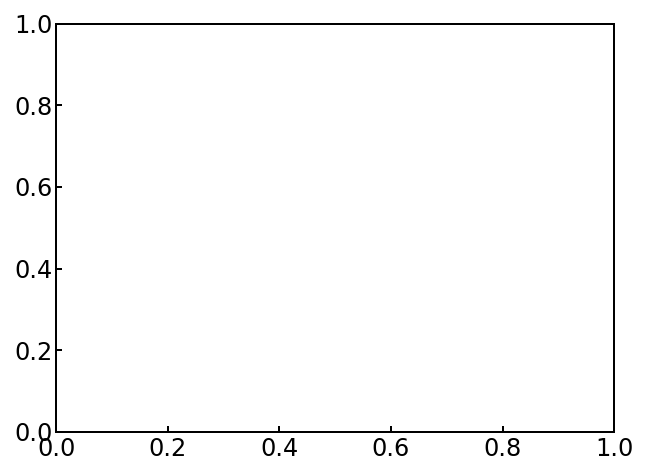

In [44]:
f_ext = 0.00001
fig, ax = plt.subplots(1,1,figsize=(10,7.5))

for row in df.itertuples():
    profile = ss_data_dict[row.run_code]
    ax.plot(profile[:,0],profile[:,1],label=[row.var0,row.kernel_type])

ax.legend()
ax.set_xlabel(r"$\frac{r}{R}$")

ax.set_ylabel(r"$\frac{u}{u_{max}}$")
plt.legend(loc="upper left")
fig.show()


#### Velocity Profile

In [ ]:
model_list = ["Newtonian","Power Law"]
fig, ax = plt.subplots(len(model_list),1,figsize=(15,15),sharex=True)

for count,value in enumerate(model_list):
    subdf = df.loc[(df.var0==value)]
    for row in subdf.itertuples():
        profile = uprof_data_dict[row.run_code]
        ax[count].plot(profile[:,0],profile[:,1],label=[row.var0,row.kernel_type])

    #analytical
    r_ref = np.linspace(0,R,25)
    r_ref_norm = r_ref/R
    u_z_ref_norm = poiseuille_analyt(r_ref, t_frame, "Newtonian")

    u_prof_analyt = np.hstack((r_ref_norm[:,None],u_z_ref_norm[:,None]))
    u_prof_analyt = u_prof_analyt[u_prof_analyt[:,0].argsort()] 

    #Plot
    plot_profile(u_prof_analyt[:,0],u_prof_analyt[:,1],run_info, ax[count], "analytic",plot_key)

    ax[count].legend(loc="lower left")
    ax[count].set_xlabel(r"$\frac{r}{R}$")
    
ax[0].set_ylabel(r"$\frac{u}{u_{max}}$")
fig.tight_layout()

# Dam Break

## Hydrostatic Column

In [ ]:
#################################
# Test-specific keys
#################################
namekey = ["var0","kernel_type","sf","hd","eta","fext"]
var1_key = {"5":"Quintic","0":"CRK0", "1":"CRK1", "2":"CRK2"}
var0_key = {"0":"Newtonian","1":"Power Law"} #Viscosity calc method
plot_key = {"Quintic":["o","#5ec962"],"CRK0":["X","#21918c"], "CRK1":["s","#3b528b"],"CRK2":["d","#440154"],
            "Analytic":["","red"],"0":"dashed","1":"dotted"} #Viridis colors
#################################
# Simulation parameters
#################################
#System dimensions
outer_R = 10
R = 6.99
d = 3 #3d
#Fluid properties
rho0 = 1
gd0 = 1e-2
npow=0.5
#Scaling parameters
nb =1
#Frame (5 before end)
frame = -1 #corresponds to t=3500

In [ ]:
#Specify filepath
infilepath = '/ascldap/users/etpaler/test/rheo_bench/channel/03_23_2022_commit/ncdf'
#Create dataframe of simulation parameters and run code for all runs
data_files = generate_file_names(infilepath)
generate_df(data_files,gen_col_names(namekey))
#Create dictionary to store simulation data
ss_data_dict = {} #dict for max velocity vs time data (to check steady state)
uprof_data_dict = {} #dict for velocity as a function of x
#Extract simulation data
for run in data_files:
    #data for ss_data_dict
    u = ds["velocities"][:,:,0]
    max_u = np.max(u,axis=1)
    t = ds["time"][:]
    t_prof = np.hstack((t[:,None],max_u[:,None]))
    t_prof = t_prof[t_prof[:,0].argsort()]
    ss_data_dict[run_info[-1]]=t_prof 
    
    #data for uprof_data_dict    
    t_frame, r, u_z = poiseuille_data(run, ds)
    r_norm = r/R
    u_z_norm = u_z/np.max(u_z)
    #Reformat the data for plotting
    u_prof = np.hstack((r_norm[:,None],u_z_norm[:,None]))
    u_prof = u_prof[u_prof[:,0].argsort()]
    #Only need R>0 because the data is symmetrical
    u_prof = u_prof[np.logical_not(u_prof[:,0] < 0)]
    uprof_data_dict[run_info[-1]]=u_prof 